In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [34]:
# Importing the dataset
df = pd.read_csv('Housing.csv')

# Checking for missing values
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


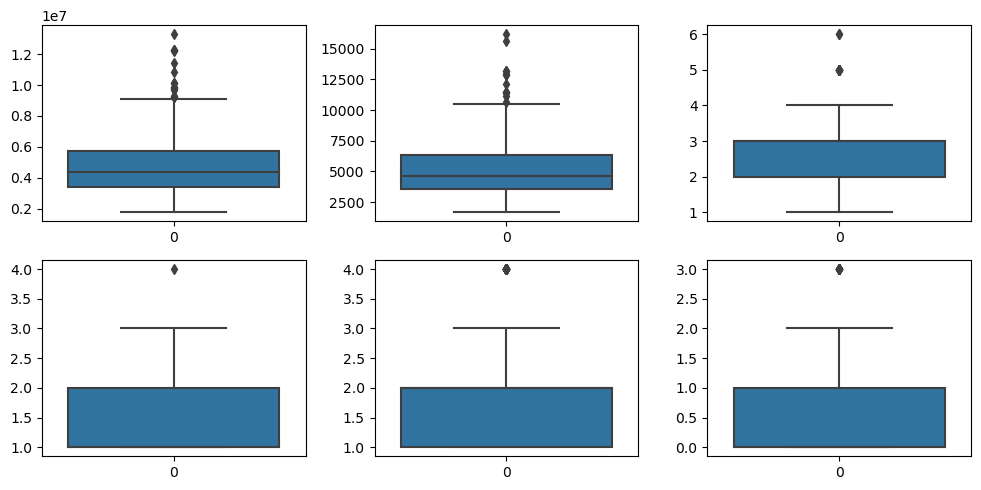

In [35]:
# Outlier Analysis
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
sns.boxplot(df['price'], ax=axs[0, 0])
sns.boxplot(df['area'], ax=axs[0, 1])
sns.boxplot(df['bedrooms'], ax=axs[0, 2])
sns.boxplot(df['bathrooms'], ax=axs[1, 0])
sns.boxplot(df['stories'], ax=axs[1, 1])
sns.boxplot(df['parking'], ax=axs[1, 2])
plt.tight_layout()

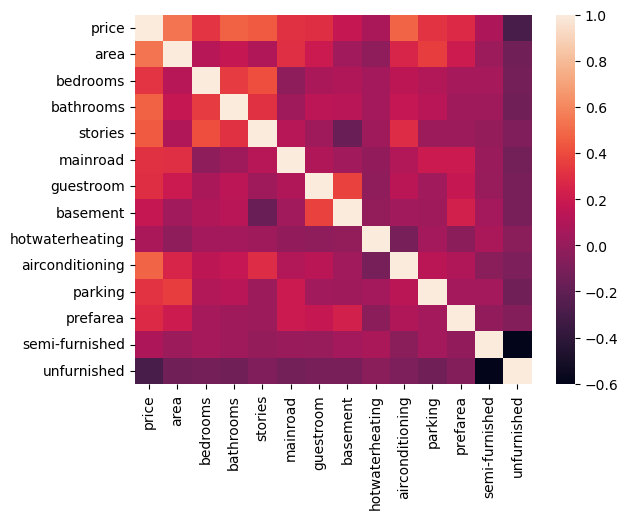

In [47]:
sns.heatmap(df.corr())
plt.show()

In [36]:
# Outlier Treatment for 'area'
Q1 = df['area'].quantile(0.25)
Q3 = df['area'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['area'] >= Q1 - 1.5 * IQR) & (df['area'] <= Q3 + 1.5 * IQR)]

# Outlier Treatment for 'price'
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]


In [37]:
# Creating dummy variables for 'furnishingstatus'
status = pd.get_dummies(df['furnishingstatus'], drop_first=True)
df = pd.concat([df, status], axis=1)
df.drop('furnishingstatus', axis=1, inplace=True)

# Mapping binary variables
varlist = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

def binary_map(x):
    return x.map({'yes': 1, "no": 0})

df[varlist] = df[varlist].apply(binary_map)

In [38]:
# Feature Scaling
scaler = MinMaxScaler()
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']
df[num_vars] = scaler.fit_transform(df[num_vars])


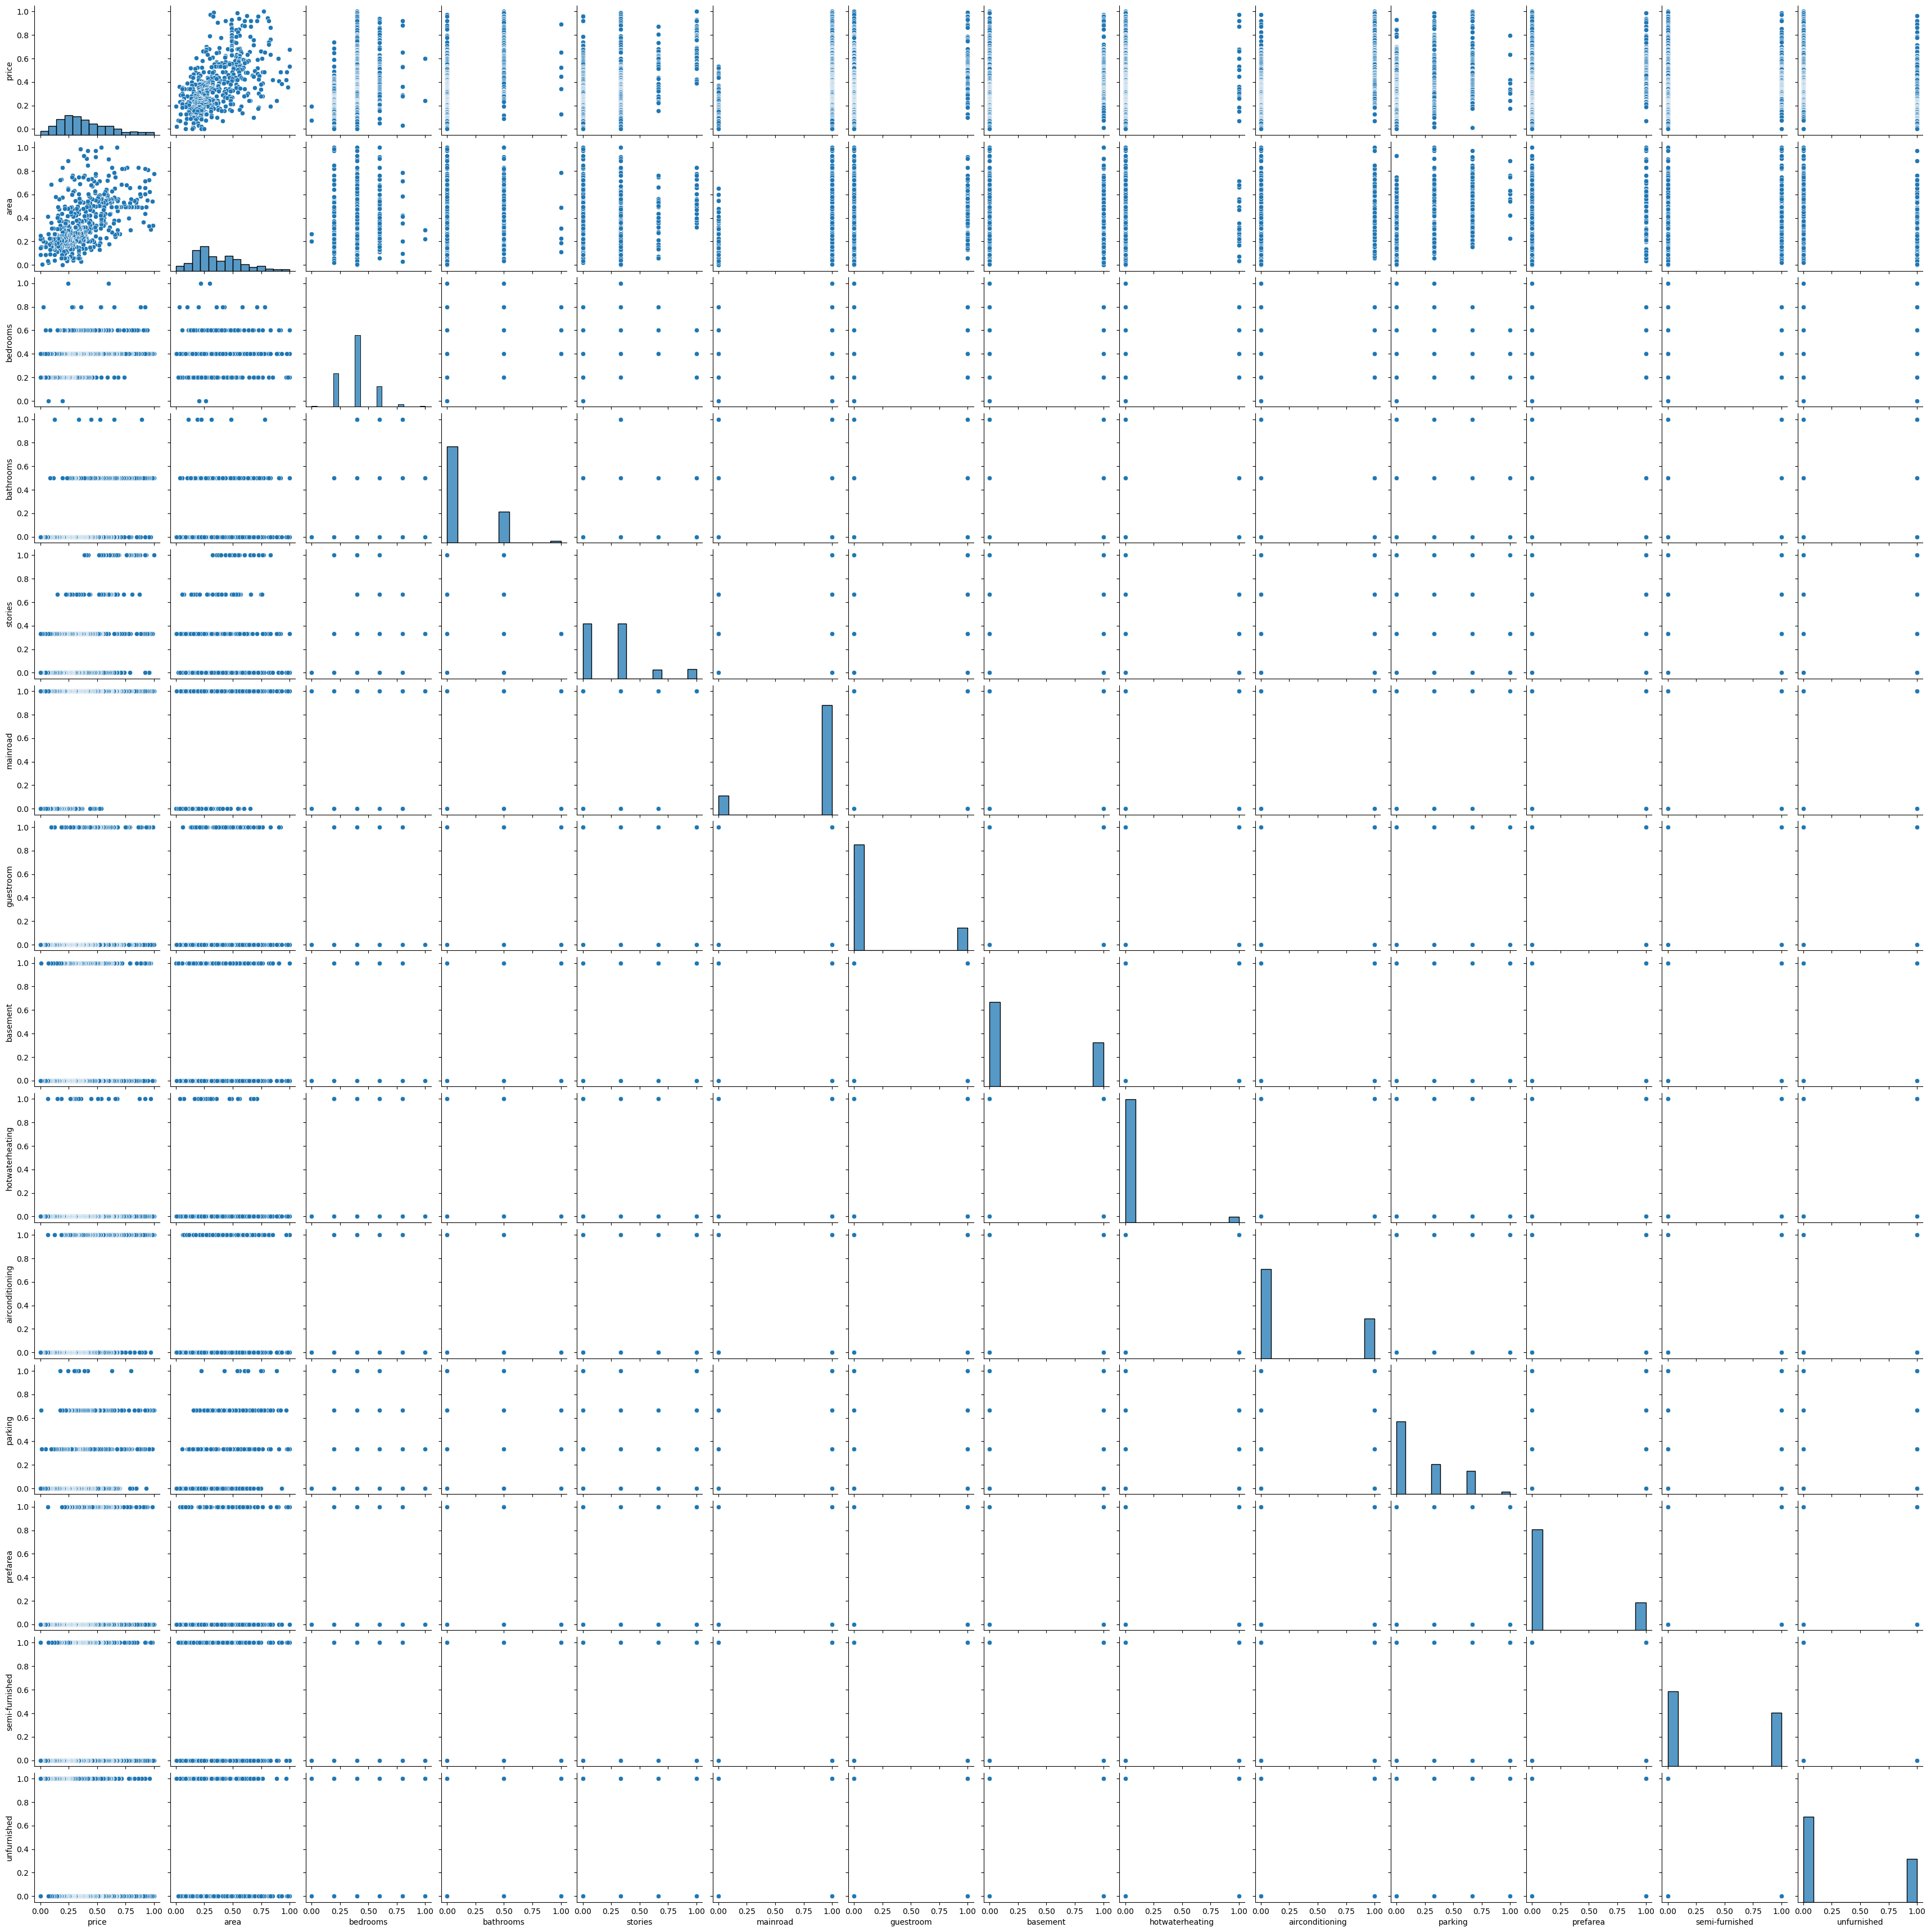

In [50]:
sns.pairplot(df)
plt.show()

In [39]:
# Splitting the data into training and testing sets
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)


In [40]:
# Feature selection using RFE
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(estimator=lm, n_features_to_select=6)
rfe = rfe.fit(X_train, y_train)


In [41]:
selected_columns = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_columns]
X_train_rfe = sm.add_constant(X_train_rfe)
ols_model = sm.OLS(y_train, X_train_rfe)
lm = ols_model.fit()


In [42]:
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     86.27
Date:                Sat, 02 Sep 2023   Prob (F-statistic):           2.65e-66
Time:                        13:41:25   Log-Likelihood:                 209.12
No. Observations:                 362   AIC:                            -404.2
Df Residuals:                     355   BIC:                            -377.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1049      0.016     

In [43]:
# Checking VIF for multicollinearity
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif = vif.sort_values(by="VIF",` ascending=False)


In [44]:
# Model Evaluation
X_test_rfe = X_test[selected_columns]
y_pred = lm.predict(sm.add_constant(X_test_rfe))


In [45]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)


0.6442943109287329

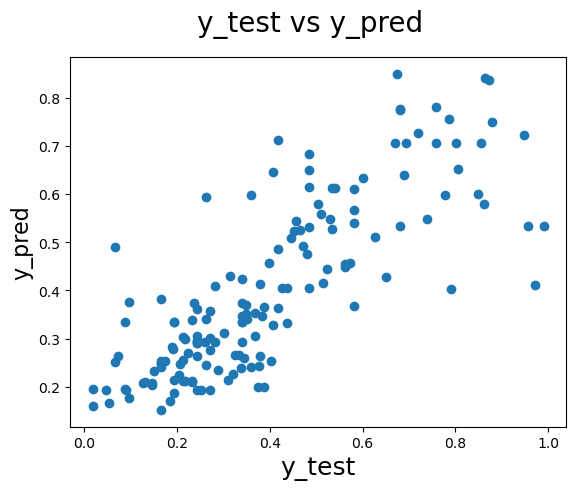

In [46]:
# Visualization
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)
plt.show()


In [51]:
y_pred = lm.predict(sm.add_constant(X_test_rfe))
print(y_pred)

365    0.275789
262    0.199360
385    0.194414
176    0.531306
273    0.241958
         ...   
530    0.250583
314    0.266235
38     0.579523
402    0.295121
183    0.492770
Length: 156, dtype: float64
